In [1]:
from data_loader import load 

import numpy as np
import matplotlib.pyplot as plt 
plt.style.use('dark_background')
import seaborn as sns
import pandas as pd 
from scipy import stats

import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
data = load("online_classroom.csv").query("format_blended==0")
data


,gender,asian,black,hawaiian,hispanic,unknown,white,format_ol,format_blended,falsexam
0,0,0.0,0.0,0.0,0.0,0.0,1.0,0,0.0,63.29997
1,1,0.0,0.0,0.0,0.0,0.0,1.0,0,0.0,79.96000
4,1,0.0,0.0,0.0,0.0,0.0,1.0,1,0.0,83.30000
5,0,1.0,0.0,0.0,0.0,0.0,0.0,1,0.0,88.34996
7,1,1.0,0.0,0.0,0.0,0.0,0.0,0,0.0,90.00000
...,...,...,...,...,...,...,...,...,...,...
316,0,0.0,0.0,0.0,0.0,0.0,1.0,0,0.0,91.65000
317,1,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,84.99000
319,1,NaN,NaN,NaN,NaN,NaN,NaN,1,0.0,70.05000
320,0,NaN,NaN,NaN,NaN,NaN,NaN,1,0.0,66.69000


In [3]:
result = smf.ols('falsexam ~ format_ol', data=data).fit()
result.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,78.5475,1.113,70.563,0.000,76.353,80.742
format_ol,-4.9122,1.680,-2.925,0.004,-8.223,-1.601


In [4]:
(data
 .groupby("format_ol")
 ["falsexam"]
 .mean())

format_ol
0    78.547485
1    73.635263
Name: falsexam, dtype: float64

intercept is $\mathbb{E}[Y|T=0]$

In [5]:
# add intercept and parameter estimate to get ATE :
(78.547485) + (-4.9122)

73.635285

ALternate way to estimate parameter, derived from regression formula:

In [6]:
kapa = data["falsexam"].cov(data["format_ol"]) / data["format_ol"].var()
kapa

-4.912221498226949

Remember if T randomly assigned, kappa is the ATE

For multiple regression with other variables auxilory reduces to a bivariate coefficient of the same regressor after accounting for affects of other variables:
1. Fit auxilory variables to response and find residual
2. Bivariate regression for treatment

(residuals orthogonal to vaqriables that created it )

# Observational Data 

In [9]:
wage = load("wage.csv").dropna()
model_1 = smf.ols('np.log(hwage) ~ educ', data=wage.assign(hwage=wage["wage"]/wage["hours"])).fit()
model_1.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2.3071,0.104,22.089,0.000,2.102,2.512
educ,0.0536,0.008,7.114,0.000,0.039,0.068


coefficient of 0.0536 on natural log scale means treatement of 1 year extra education (T=1) increases wages by 5.36%

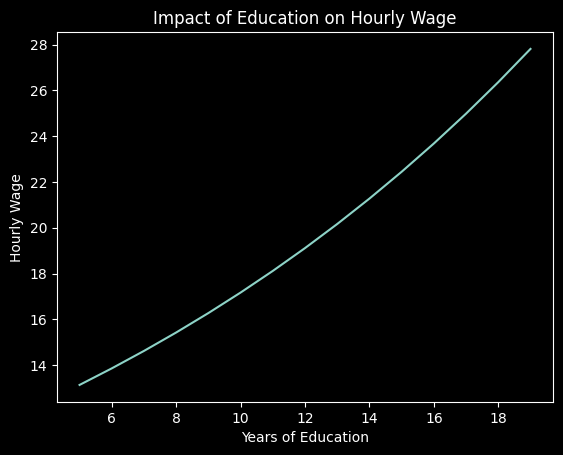

In [10]:
from matplotlib import pyplot as plt

x = np.array(range(5, 20))
plt.plot(x, np.exp(model_1.params["Intercept"] + model_1.params["educ"] * x))
plt.xlabel("Years of Education")
plt.ylabel("Hourly Wage")
plt.title("Impact of Education on Hourly Wage")
plt.show()

This is purely a prediction model. We can't infer much causality from it. Prediction and causality are two very different things.

With this data we can assume $\mathbb{E}[Y^0 | T = 0 ] < \mathbb{E}[Y^0 | T = 1 ]$ or that educated/treated have a higher baseline maybe due to family wealth. To attempt to find some causal relationship we must control on other variables in the data 

In [11]:
wage.head()

,wage,hours,lhwage,IQ,educ,exper,tenure,age,married,black,south,urban,sibs,brthord,meduc,feduc
0,769,40,2.956212,93,12,11,2,31,1,0,0,1,1,2.0,8.0,8.0
2,825,40,3.026504,108,14,11,9,33,1,0,0,1,1,2.0,14.0,14.0
3,650,40,2.788093,96,12,13,7,32,1,0,0,1,4,3.0,12.0,12.0
4,562,40,2.642622,74,11,14,5,34,1,0,0,1,10,6.0,6.0,11.0
6,600,40,2.708050,91,10,13,0,30,0,0,0,1,1,2.0,8.0,8.0


In [12]:
def regress(y, X): 
    return np.linalg.inv(X.T.dot(X)).dot(X.T.dot(y))
    
controls = ['IQ', 'exper', 'tenure', 'age', 'married', 'black',
            'south', 'urban', 'sibs', 'brthord', 'meduc', 'feduc']

X = wage[controls].assign(intercep=1)
t = wage["educ"]
y = wage["lhwage"]

beta_aux = regress(t, X)
beta_aux # holds coeeficient for auxillary parameters

array([ 0.05856182, -0.23207639,  0.01165998,  0.20166154, -0.15743669,
        0.66079   ,  0.20307728,  0.18274787, -0.05397904,  0.01139721,
        0.05796792,  0.11222276,  1.82720507])

In [13]:
t_tilde = t - X.dot(beta_aux)

kappa = t_tilde.cov(y) / t_tilde.var()
kappa

0.041147191010059134

THis coeffeicent 0.04 says that for units with the same control we expect an extra year of education (treament =1 ) to have 4.11% inc in wage

In [14]:
# samething with statmodels so we get some nice confidence 
model_2 = smf.ols('lhwage ~ educ +' + '+'.join(controls), data=wage).fit()
model_2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.1156,0.232,4.802,0.000,0.659,1.572
educ,0.0411,0.010,4.075,0.000,0.021,0.061
IQ,0.0038,0.001,2.794,0.005,0.001,0.006
exper,0.0153,0.005,3.032,0.003,0.005,0.025
tenure,0.0094,0.003,2.836,0.005,0.003,0.016
age,0.0086,0.006,1.364,0.173,-0.004,0.021
married,0.1795,0.053,3.415,0.001,0.076,0.283
black,-0.0801,0.063,-1.263,0.207,-0.205,0.044
south,-0.0397,0.035,-1.129,0.259,-0.109,0.029
urban,0.1926,0.036,5.418,0.000,0.123,0.262


To argue causation we must argue we have controlled for everything that requires controlling 

Formally we have ommited 'ability factors '

"Short equals long 
plus the effect of omitted,
times the regression of omitted on included"

In [15]:
import graphviz as gr

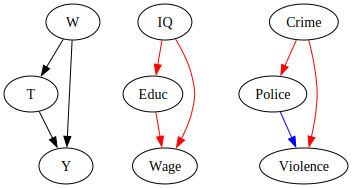

In [16]:
g = gr.Digraph()

g.edge("W", "T"), g.edge("W", "Y"), g.edge("T", "Y")

g.edge("IQ", "Educ", color="red"), g.edge("IQ", "Wage", color="red"), g.edge("Educ", "Wage", color="red")

g.edge("Crime", "Police", color="red"), g.edge("Crime", "Violence", color="red"), 
g.edge("Police", "Violence", color="blue")

g